In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Reading Data

In [39]:

def read_data(threads, num_cols, implementations, densities, file_name):
    # Initialize nested dictionaries
    gflops = {imp: {n: {t: [] for t in threads} for n in num_cols} for imp in implementations}
    gflops_density = {imp: {n: {t: {d: [] for d in densities} for t in threads} for n in num_cols} for imp in implementations}
    gflops_median = {imp: {n: {t: [] for t in threads} for n in num_cols} for imp in implementations}
    gflops_density_median = {imp: {n: {t: {d: [] for d in densities} for t in threads} for n in num_cols} for imp in implementations}

    for n in num_cols:
        for imp in implementations:
            for t in threads:
                try:
                    # Construct the file path
                    file_path = f"{file_name}{n}/{imp}_f_{t}.csv"
                    data_r = pd.read_csv(file_path)

                    # Precompute filtered rows
                    filtered_rows = [row[7] if (not np.isnan(row[5]) and row[7]!=0.0) else 0 for row in data_r.values]

                    # Populate gflops and gflops_median
                    gflops[imp][n][t] = filtered_rows
                    gflops_median[imp][n][t] = np.median(filtered_rows)

                    # Populate gflops_density and gflops_density_median
                    for d in densities:
                        density_rows = [row[7] for row in data_r.values if (d+'/') in str(row[0]) and row[7]!=0.0]
                        gflops_density[imp][n][t][d] = density_rows
                        # print(f"GFLOPS den for {imp}, num_cols={n}, threads={t}, density={d}: {len(gflops_density[imp][n][t][d])}")
                        gflops_density_median[imp][n][t][d] = np.median(density_rows) if density_rows else 0

                    # Print for verification
                    # print(f"GFLOPS for {imp}, num_cols={n}, threads={t}: {gflops_median[imp][n][t]}")

                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")
                    gflops[imp][n][t] = []
                    gflops_median[imp][n][t] = 0

    return gflops, gflops_median, gflops_density, gflops_density_median

In [40]:
def read_data_with_sparsification(threads, num_cols, implementations, densities, sparsifications, file_name):
    """
    Reads data and organizes it into a 4D dictionary structure with dimensions for:
    implementations, num_cols, threads, densities, and sparsification methods.
    """
    gflops = {
        imp: {
            n: {
                t: {
                    d: {s: [] for s in sparsifications} for d in densities
                } for t in threads
            } for n in num_cols
        } for imp in implementations
    }

    for n in num_cols:
        for imp in implementations:
            for t in threads:
                try:
                    # Construct the file path
                    file_path = f"{file_name}{n}/{imp}_f_{t}.csv"
                    data_r = pd.read_csv(file_path)

                    for d in densities:
                        for s in sparsifications:
                            # Filter rows that match both density and sparsification method
                            gflops[imp][n][t][d][s] = [
                                row[7]
                                for row in data_r.values
                                if (d + '/') in str(row[0]) and s in str(row[0]) and not np.isnan(row[7]) and row[7] != 0
                            ]

                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")
                    for d in densities:
                        for s in sparsifications:
                            gflops[imp][n][t][d][s] = []  # Assign empty lists in case of error

    return gflops

In [58]:
threads=['1','2','4','8','12','16','24']
densities=['0.5','0.6','0.7','0.8','0.9','0.95','0.98']
num_cols=['512']
implementations=["mkl_csr", "mkl_ie", "csr_naive", "mkl_gemm"]
file_name="spmm-scalability-n="

gflops, gflops_median, gflops_density, gflops_density_median=read_data(threads,num_cols,implementations,densities,file_name)

In [42]:
import matplotlib.pyplot as plt

def plot_scalability(implementation, threads, densities, num_cols, gflops_density_median, file_name, speedup=False):
    """
    Plots the scalability of an implementation across different threads and densities.
    
    Parameters:
        implementation (str): The implementation to plot (e.g., 'mkl_csr').
        threads (list of str): List of thread counts (e.g., ['2', '4', '8', ...]).
        densities (list of str): List of densities to represent different lines (e.g., ['0.5', '0.6', ...]).
        num_cols (list of str): List of column sizes (assume single value for simplicity, e.g., ['64']).
        gflops_density (dict): Precomputed GFLOPS data structured as {imp: {n: {t: {d: []}}}}.
        file_name (str): Base file name or description for labeling.
    """
    # Ensure we are working with a single column size
    if len(num_cols) > 1:
        print("This function assumes a single num_cols value. Using the first one.")
    n = num_cols[0]

    plt.figure(figsize=(10, 6))
    
    for d in densities:
        # Extract GFLOPS data for this density
        y_values = [np.median(gflops_density[implementation][n][t][d]) if gflops_density[implementation][n][t][d] else 0 for t in threads]
        if speedup:
            y_values=[y/y_values[0] for y in y_values]
        # y_values = gflops_density_median
        plt.plot(
            list(map(int, threads)),  # Convert threads to integers for proper scaling on the x-axis
            y_values,
            marker='o',
            label=f"Sparsity {d}"
        )

    # Customize the plot
    if speedup:
        plt.title(f"Speed-up Plot for {implementation} (n={n})")
    else:
        plt.title(f"Scalability Plot for {implementation} (n={n})")
    plt.xlabel("Threads")
    plt.ylabel("GFLOPS")
    plt.legend(title="Sparsity")
    plt.grid(True)
    plt.xticks(list(map(int, threads)))  # Ensure thread counts are shown as x-ticks
    plt.tight_layout()

    # Save the plot or display it
    if speedup:
        plot_file = f"speedup_{implementation}_n{n}.png"
    else:
        plot_file = f"scalability_{implementation}_n{n}.png"
    plt.savefig(plot_file, dpi=300)
    print(f"Plot saved as {plot_file}")
    plt.show()


In [43]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scalability_boxplot(implementation, threads, densities, num_cols, gflops_density, file_name):
    """
    Creates a grouped scalability boxplot for GFLOPS data across threads and densities.
    
    Parameters:
        implementation (str): The implementation to plot (e.g., 'mkl_csr').
        threads (list of str): List of thread counts (e.g., ['2', '4', '8', ...]).
        densities (list of str): List of densities (e.g., ['0.5', '0.6', ...]).
        num_cols (list of str): List of column sizes (assume single value for simplicity, e.g., ['64']).
        gflops_density (dict): Precomputed GFLOPS data structured as {imp: {n: {t: {d: []}}}}.
        file_name (str): Base file name or description for labeling.
    """
    # Ensure we are working with a single column size
    if len(num_cols) > 1:
        print("This function assumes a single num_cols value. Using the first one.")
    n = num_cols[0]

    plt.figure(figsize=(12, 6))
    
    # Prepare data for the boxplot
    data = []
    colors = plt.cm.viridis(np.linspace(0, 1, len(densities)))  # Generate unique colors for densities
    positions = []
    density_legend_labels = []
    base_position = 0

    for idx, t in enumerate(threads):
        for d_idx, d in enumerate(densities):
            # Collect GFLOPS data for the current thread and density
            values = gflops_density[implementation][n][t][d] if gflops_density[implementation][n][t][d] else []
            data.append(values)
            positions.append(base_position + d_idx)

            # Add density label only once for the legend
            if idx == 0:
                density_legend_labels.append(f"Sparsity {d}")

        base_position += len(densities) + 1  # Add spacing between groups of densities

    # Create the boxplot
    box = plt.boxplot(
        data, 
        positions=positions, 
        patch_artist=True, 
        showfliers=True, 
        widths=0.6
    )

    # Color the boxes by density
    repeated_colors = [colors[i % len(colors)] for i in range(len(box['boxes']))]
    for patch, color in zip(box['boxes'], repeated_colors):
        patch.set_facecolor(color)


    # Add thread labels
    group_positions = np.arange(len(densities) / 2, base_position, len(densities) + 1)
    plt.xticks(group_positions, threads)
    plt.xlabel("Threads")
    plt.ylabel("GFLOPS")
    plt.title(f"Scalability Boxplot for {implementation} (n={n})")

    # Add density legend
    for color, label in zip(colors, density_legend_labels):
        plt.plot([], [], color=color, marker='s', linestyle='', markersize=10, label=label)
    plt.legend(title="Sparsities", loc="upper left", bbox_to_anchor=(1.05, 1))

    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()

    # Save the plot or display it
    plot_file = f"boxplot_{implementation}_n{n}.png"
    plt.savefig(plot_file, dpi=300)
    print(f"Boxplot saved as {plot_file}")
    plt.show()




In [44]:
import matplotlib.pyplot as plt
import numpy as np

def plot_density_scalability(implementations, thread, densities, num_cols, gflops_density_median, file_name):
    """
    Plots the scalability of multiple implementations across different densities for a fixed number of threads.

    Parameters:
        implementations (list of str): List of implementations to plot (e.g., ['mkl_csr', 'mkl_ie']).
        thread (str): The thread count to use for plotting (e.g., '8').
        densities (list of str): List of densities to represent on the x-axis (e.g., ['0.5', '0.6', ...]).
        num_cols (list of str): List of column sizes (assume single value for simplicity, e.g., ['64']).
        gflops_density_median (dict): Precomputed GFLOPS median data structured as {imp: {n: {t: {d: median}}}}.
        file_name (str): Base file name or description for labeling.
    """
    # Ensure we are working with a single column size
    if len(num_cols) > 1:
        print("This function assumes a single num_cols value. Using the first one.")
    n = num_cols[0]

    plt.figure(figsize=(10, 6))
    
    for imp in implementations:
        # Extract GFLOPS median data for this implementation and thread
        y_values = [
            gflops_density_median[imp][n][thread][d] if d in gflops_density_median[imp][n][thread] else 0
            for d in densities
        ]
        
        plt.plot(
            list(map(float, densities)),  # Convert densities to floats for proper scaling on the x-axis
            y_values,
            marker='o',
            label=f"{imp}"
        )

    # Customize the plot
    plt.title(f"Sparsity Scalability for Fixed Threads ({thread}) (n={n})")
    plt.xlabel("Sparsity")
    plt.ylabel("Median GFLOPS")
    plt.legend(title="Implementation")
    plt.grid(True)
    plt.xticks(list(map(float, densities)))  # Ensure densities are shown as x-ticks
    plt.tight_layout()

    # Save the plot or display it
    plot_file = f"scalability_density_threads_{thread}_n{n}.png"
    plt.savefig(plot_file, dpi=300)
    print(f"Plot saved as {plot_file}")
    plt.show()


In [56]:
def plot_density_sparsification(implementation, thread, densities, num_cols, sparsifications, gflops, file_name):
    """
    Plots scalability of a single implementation across different densities with lines for sparsification methods.

    Parameters:
        implementation (str): The implementation to plot (e.g., 'mkl_csr').
        thread (str): The thread count to use for plotting (e.g., '8').
        densities (list of str): List of densities to represent on the x-axis (e.g., ['0.5', '0.6', ...]).
        num_cols (list of str): List of column sizes (assume single value for simplicity, e.g., ['64']).
        sparsifications (list of str): List of sparsification methods (e.g., ['l0_regularization', ...]).
        gflops (dict): Precomputed GFLOPS data structured as {imp: {n: {t: {d: {s: []}}}}}.
        file_name (str): Base file name or description for labeling.
    """
    # Ensure we are working with a single column size
    if len(num_cols) > 1:
        print("This function assumes a single num_cols value. Using the first one.")
    n = num_cols[0]

    plt.figure(figsize=(10, 6))
    
    for s in sparsifications:
        # Extract GFLOPS data for this sparsification method
        y_values = [
            np.median(gflops[implementation][n][thread][d][s]) if gflops[implementation][n][thread][d][s] else 0
            for d in densities
        ]
        
        plt.plot(
            list(map(float, densities)),  # Convert densities to floats for proper scaling on the x-axis
            y_values,
            marker='o',
            label=f"Sparsification: {s}"
        )

    # Customize the plot
    plt.title(f"Sparsification impact for {implementation} (Threads={thread}, n={n})")
    plt.xlabel("Sparsity")
    plt.ylabel("Median GFLOPS")
    plt.legend(title="Sparsification")
    plt.grid(True)
    plt.xticks(list(map(float, densities)))  # Ensure densities are shown as x-ticks
    plt.tight_layout()

    # Save the plot or display it
    plot_file = f"sparsification_{implementation}_threads_{thread}_n{n}.png"
    plt.savefig(plot_file, dpi=300)
    print(f"Plot saved as {plot_file}")
    plt.show()

Plot saved as scalability_mkl_csr_n512.png


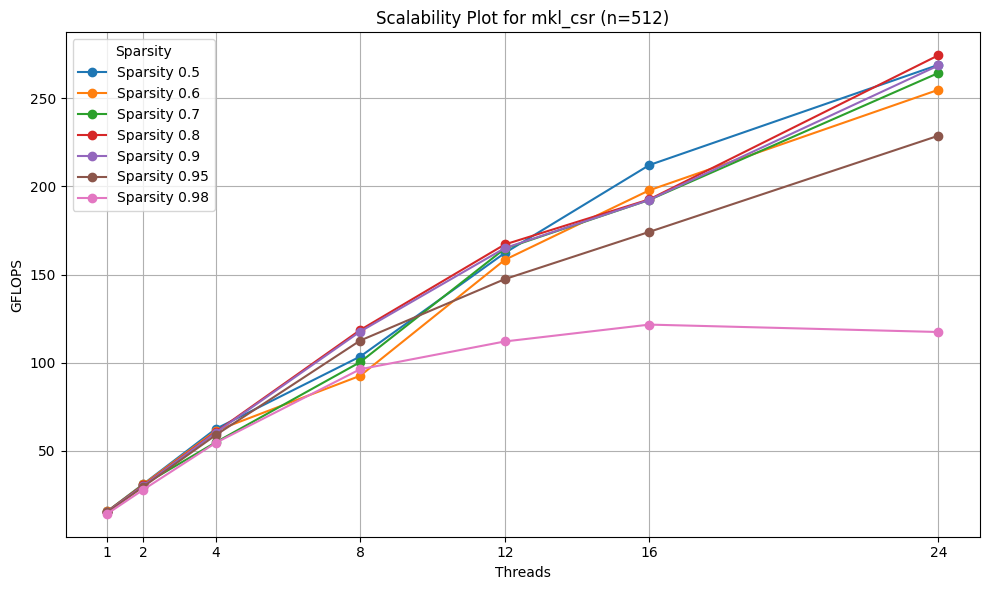

In [46]:
plot_scalability("mkl_csr", threads, densities, num_cols, gflops_density, file_name)

Plot saved as scalability_mkl_ie_n512.png


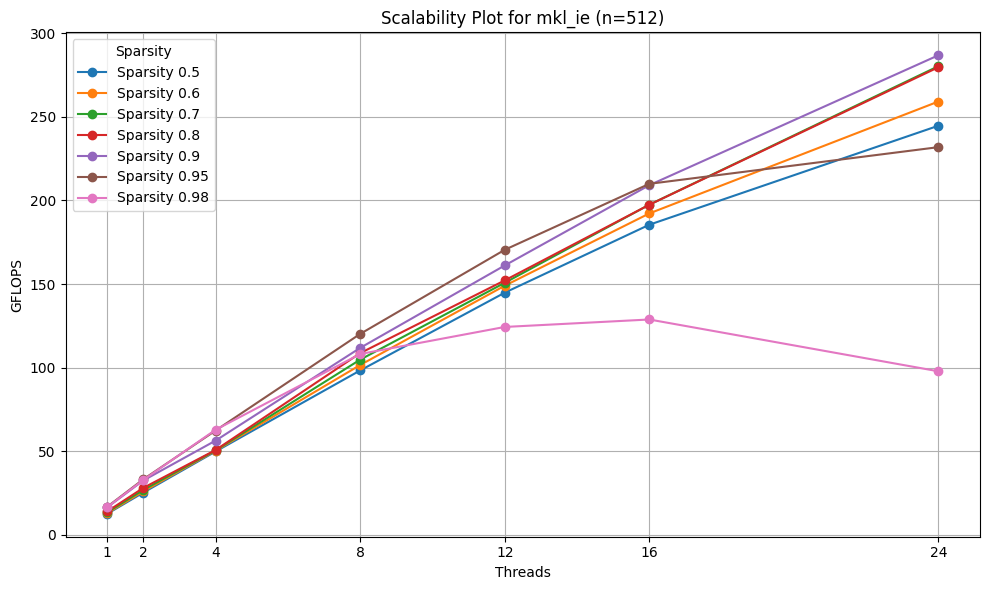

In [47]:
plot_scalability("mkl_ie", threads, densities, num_cols, gflops_density, file_name)

Plot saved as speedup_mkl_ie_n512.png


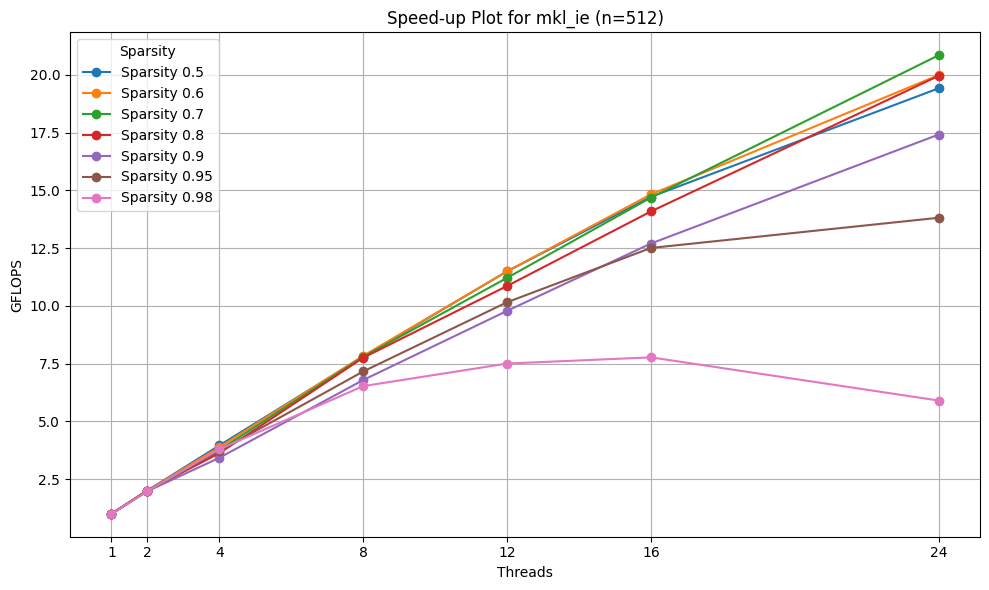

In [48]:
plot_scalability("mkl_ie", threads, densities, num_cols, gflops_density, file_name, True)

Plot saved as scalability_csr_naive_n512.png


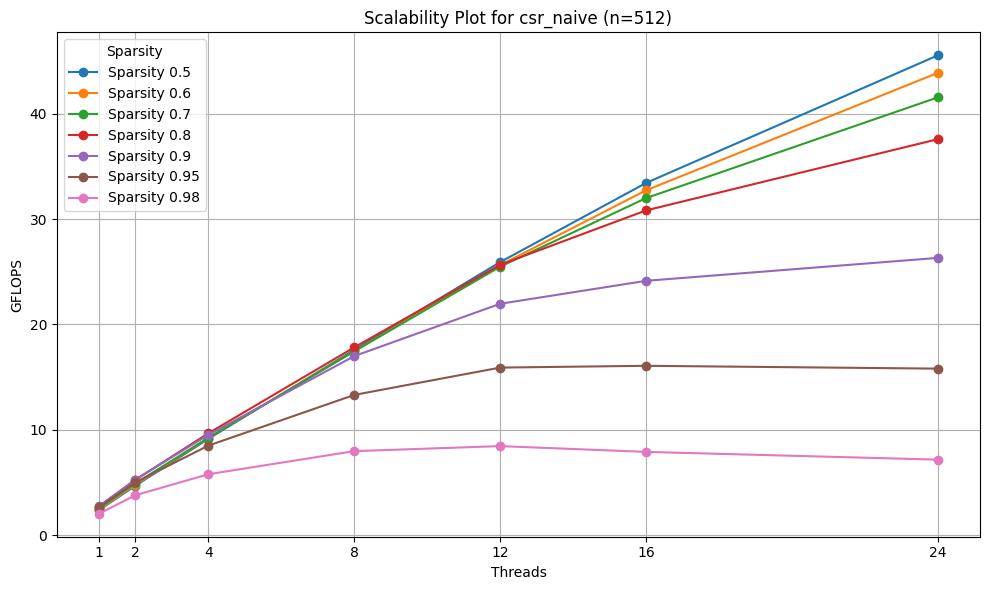

In [49]:
plot_scalability("csr_naive", threads, densities, num_cols, gflops_density, file_name)

Plot saved as scalability_mkl_gemm_n512.png


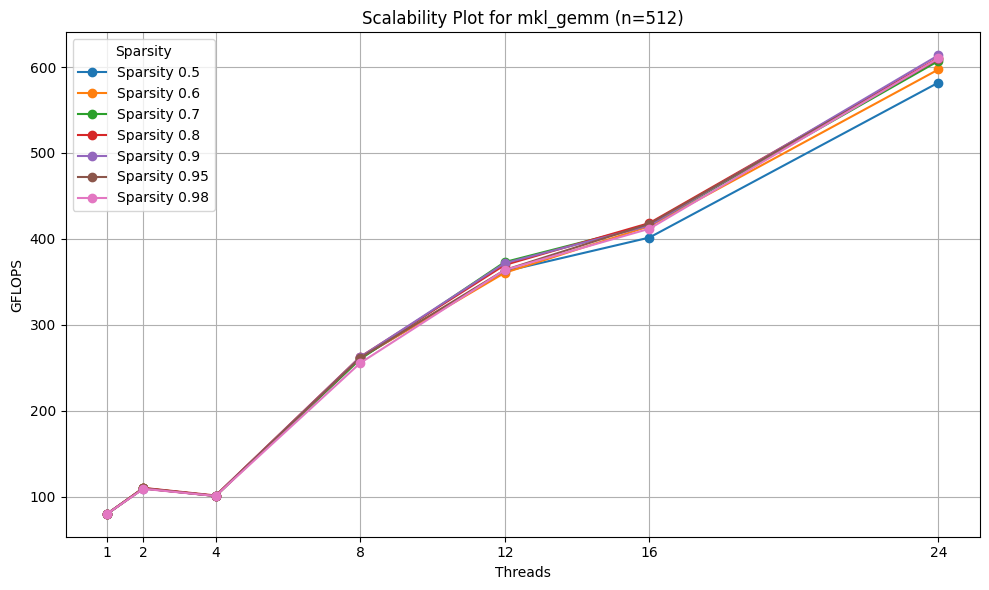

In [50]:
plot_scalability("mkl_gemm", threads, densities, num_cols, gflops_density, file_name)

Plot saved as speedup_mkl_gemm_n512.png


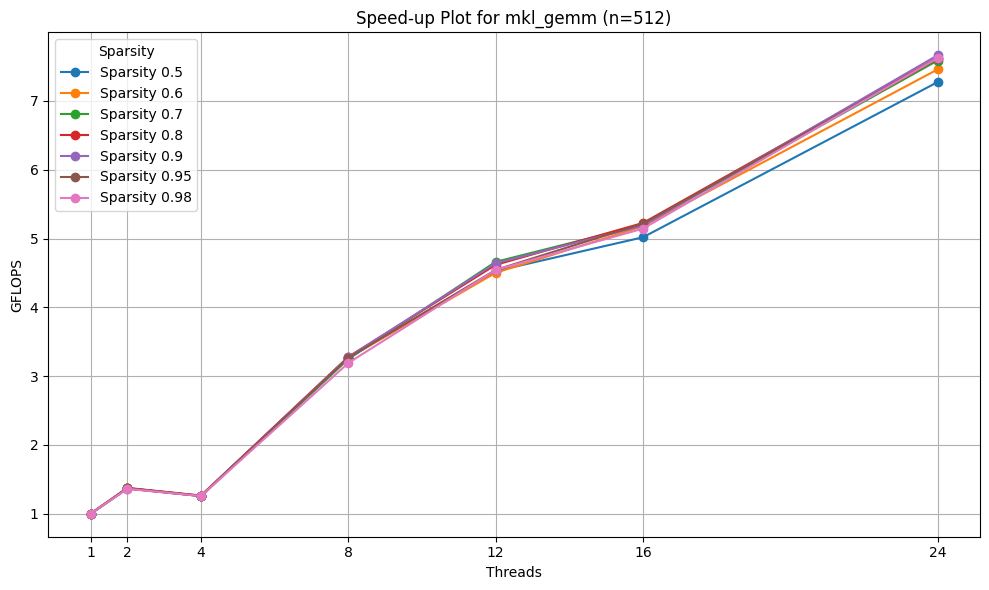

In [51]:
plot_scalability("mkl_gemm", threads, densities, num_cols, gflops_density, file_name, True)

Boxplot saved as boxplot_mkl_ie_n512.png


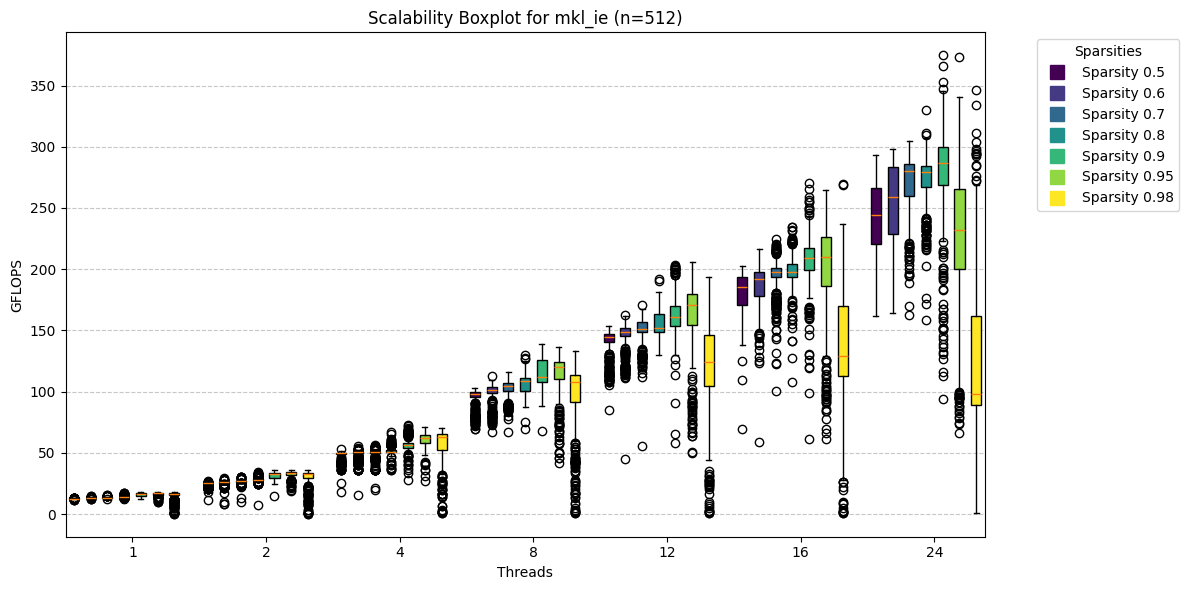

In [52]:
plot_scalability_boxplot("mkl_ie", threads, densities, num_cols, gflops_density, file_name)

Boxplot saved as boxplot_mkl_ie_n512.png


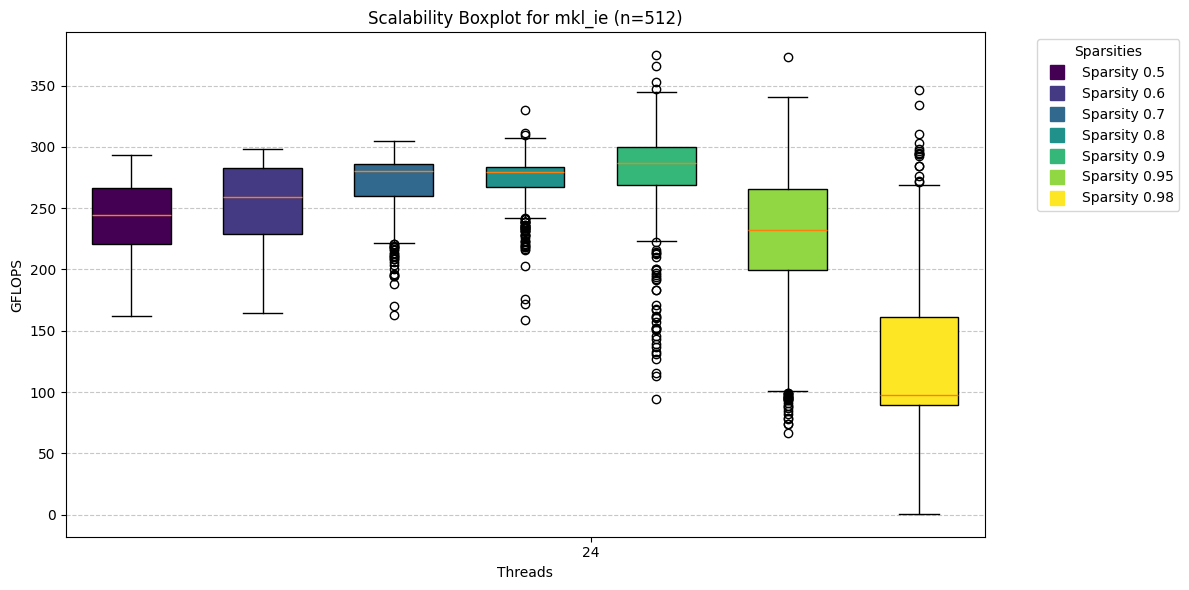

In [53]:
plot_scalability_boxplot("mkl_ie", ['24'], densities, num_cols, gflops_density, file_name)

Plot saved as scalability_density_threads_24_n512.png


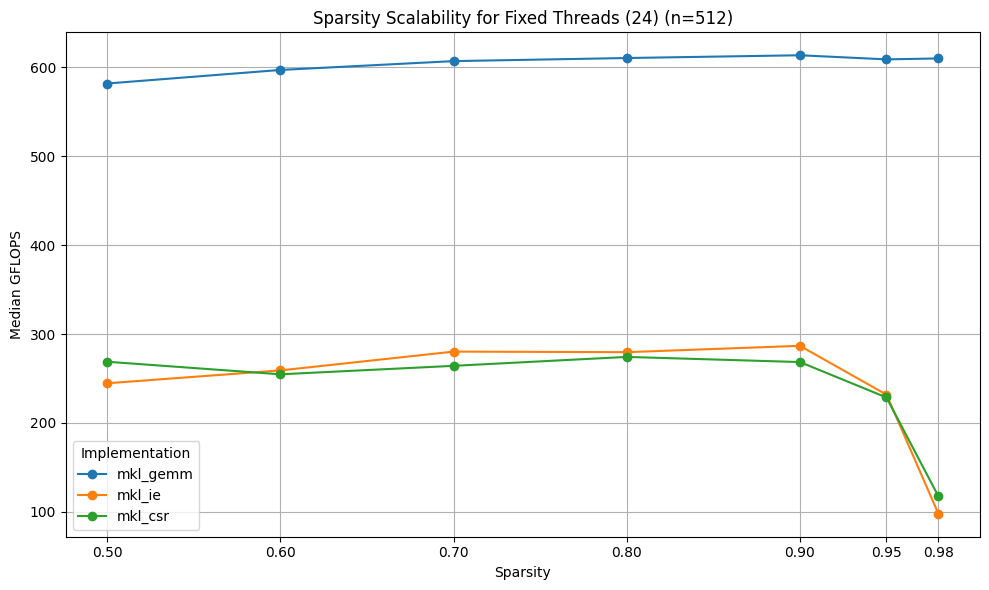

In [54]:
densities = ['0.5', '0.6', '0.7', '0.8', '0.9', '0.95', '0.98']
num_cols = ['512']
implementations = ["mkl_gemm", "mkl_ie", "mkl_csr"]
file_name = "spmm-scalability-n="

# Assume `gflops_density_median` is computed using your data-processing function
plot_density_scalability(implementations, thread='24', densities=densities, num_cols=num_cols, gflops_density_median=gflops_density_median, file_name=file_name)


Plot saved as sparsification_mkl_ie_threads_24_n512.png


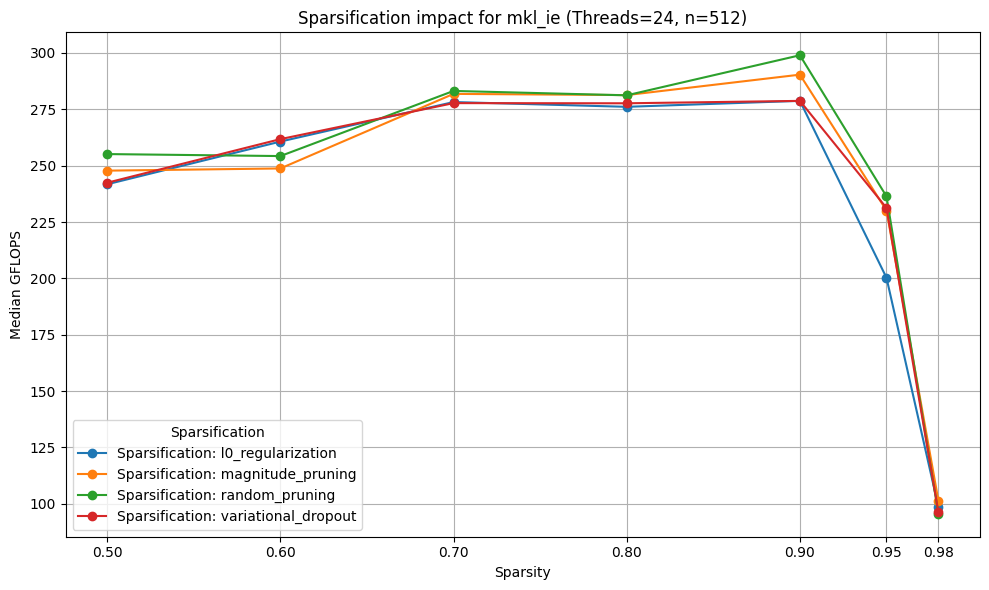

In [57]:
densities = ['0.5', '0.6', '0.7', '0.8', '0.9', '0.95', '0.98']
num_cols = ['512']
sparsifications = ['l0_regularization', 'magnitude_pruning', 'random_pruning', 'variational_dropout']
file_name = "spmm-scalability-n="

# Generate GFLOPS data
gflops_sp = read_data_with_sparsification(threads, num_cols, implementations, densities, sparsifications, file_name)

# Plot for a single implementation
plot_density_sparsification(
    implementation="mkl_ie",
    thread='24',
    densities=densities,
    num_cols=num_cols,
    sparsifications=sparsifications,
    gflops=gflops_sp,
    file_name=file_name
)